### Goal

A/B tests play a huge role in website optimization. Analyzing A/B tests data is a very important data scientist responsibility. Especially, data scientists have to make sure that results are reliable, trustworthy and conclusions can be drawn.

Furthermore, companies often run tens, if not hundreds, of A/B tests at the same time. Manually analyzing all of them would require lot of time and people. Therefore, it is common practice to look at the typical A/B test analysis steps and try to automate as much as possible. This frees up time for the data scientist to work on more high level topics.

In this challenge, 
1. you will have to analyze results from an A/B test. 
2. you will be asked to design an algorithm to automate some steps.

#### Challenge Description

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. Therefore, they agreed to try a test where each country would have its own translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users written by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised because the test is negative. That is, it appears that the non-highly localized translation was doing better!


You are asked to:

1. Confirm that test is actually negative. I.e., the old version of the site with just one translation across Spain and LatAm performs better

2. Explain why that might be happening. Are the localized translations really worse?

3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and results can be trusted.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 550)

### Part I: Load Data and Exploration

In [72]:
user = pd.read_csv("user_table.csv")
test = pd.read_csv("test_table.csv")

In [26]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [27]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


#### 数据质量
1. 完整性 单条数据是否存在空值，统计的字段是否完善。 isnull, dropna, fillna
2. 全面性 平均值、最大值、最小值。我们可以通过常识来判断该列是否有问题，比如：数据定义、单位标识、数值本身。 describe()
3. 合法性：数据的类型、内容、大小的合法性。比如数据中存在非 ASCII 字符，性别存在了未知，年龄超过了 150 岁等
4. 唯一性: 数据是否存在重复记录，因为数据通常来自不同渠道的汇总，重复的情况是常见的 drop_duplicates

In [28]:
# shape

print ("user shape is", user.shape)
print("test shape is", test.shape)

user shape is (452867, 4)
test shape is (453321, 9)


In [29]:
# 全面性

print ("test describe is:\n",test.describe())
print ("user describe is:\n",user.describe())

test describe is:
               user_id     conversion           test
count   453321.000000  453321.000000  453321.000000
mean    499937.514728       0.049579       0.476446
std     288665.193436       0.217073       0.499445
min          1.000000       0.000000       0.000000
25%     249816.000000       0.000000       0.000000
50%     500019.000000       0.000000       0.000000
75%     749522.000000       0.000000       1.000000
max    1000000.000000       1.000000       1.000000
user describe is:
               user_id            age
count   452867.000000  452867.000000
mean    499944.805166      27.130740
std     288676.264784       6.776678
min          1.000000      18.000000
25%     249819.000000      22.000000
50%     500019.000000      26.000000
75%     749543.000000      31.000000
max    1000000.000000      70.000000


In [30]:
# 唯一性 uniqueniess

print( "test user_id is unique?",test['user_id'].nunique()==len(test['user_id']))

print( "user user_id is unique?",user['user_id'].nunique()==len(user['user_id']))

print ("length of user_id in user table ", len(user['user_id']))

print ("length of user_id in test table ", len(test['user_id']))

test user_id is unique? True
user user_id is unique? True
length of user_id in user table  452867
length of user_id in test table  453321


In [73]:
#join

data = pd.merge(test, user, on ="user_id")
data['date'] = pd.to_datetime(data['date'])
print(data.describe(include = 'all'))

               user_id                 date  source  device browser_language ads_channel      browser     conversion           test     sex            age country
count    452867.000000               452867  452867  452867           452867      181693       452867  452867.000000  452867.000000  452867  452867.000000  452867
unique             NaN                    5       3       2                3           5            7            NaN            NaN       2            NaN      17
top                NaN  2015-12-04 00:00:00     Ads     Web               ES    Facebook  Android_App            NaN            NaN       M            NaN  Mexico
freq               NaN               141024  181693  251316           377160       68358       154977            NaN            NaN  264485            NaN  128484
first              NaN  2015-11-30 00:00:00     NaN     NaN              NaN         NaN          NaN            NaN            NaN     NaN            NaN     NaN
last               NaN

In [32]:
import seaborn as sns

In [33]:
data2 = data.query('country != "spain"')

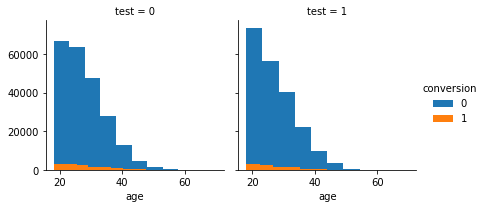

In [34]:
# distribution of Age for two groups

g= sns.FacetGrid(data2, hue='conversion', col='test')
g.map(plt.hist, 'age')
g.add_legend()

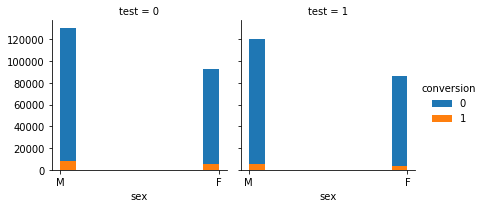

In [35]:
# distribution of country for two groups

g= sns.FacetGrid(data, col = 'test', hue='conversion')
g.map(plt.hist, 'sex')
g.add_legend()

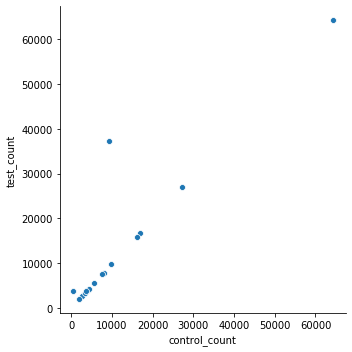

In [36]:
## check the country sampling

country_cnt_control= data.query('test==0').groupby('country')['country'].count().reset_index(name="control_count")
country_cnt_test= data.query('test==1').groupby('country')['country'].count().reset_index(name="test_count")
type(country_cnt_control)
data_country= pd.merge(country_cnt_control, country_cnt_test, how = 'outer', on ='country')

data_country.head()

sns.relplot(x='control_count', y= 'test_count', data = data_country)

#### confirming the conversion rate

#### A/B test result

In [87]:
from scipy import stats

# nothing changed in Spain, new dataset without Spain

data = data.query('country !="Spain"')
print(data.groupby('test')['conversion'].mean())

# t-test of test and control for our target metric

test = stats.ttest_ind(data[data["test"]==1]['conversion'], data[data["test"]==0]['conversion'], equal_var= False)



test
0    0.048292
1    0.043411
Name: conversion, dtype: float64


In [88]:
print ("t-test statistic:", test.statistic)
print ("t-test p-value:", test.pvalue)

t-test statistic: -7.353895203080277
t-test p-value: 1.9289178577799033e-13


In [89]:
data2 = data.query('country =="Argentina"')
data2.head()

print(data2.groupby('test')['conversion'].mean())

test= stats.ttest_ind(data2[data2['test'] ==1]['conversion'], data2[data2['test']==0]['conversion'], equal_var=False)



test
0    0.015071
1    0.013725
Name: conversion, dtype: float64


In [90]:
print ("t-test statistic:", test.statistic)
print ("t-test p-value:", test.pvalue)

t-test statistic: -0.9638326839451179
t-test p-value: 0.3351465468746866


Mmh…control users are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop, which would be dramatic if it were true. The most likely reason for weird A/B test results are: 

1) We didn’t collect enough data 

2) Some bias has been introduced in the experiment so that test/control people are not really random 


In data science, whenever results appear too bad or too good to be true, they are not true.

Firstly, let’s plot day by day, to see if these weird results have been constantly happening or they just started happening all of a sudden. 

### A/B test reason exploring

C:\Users\jmeng\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


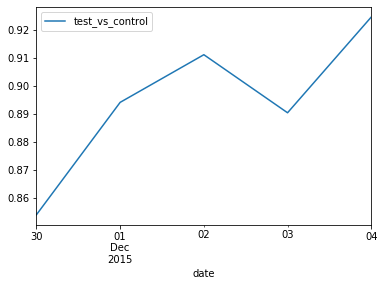

In [40]:
data_test_by_day = data.groupby('date')['conversion'].agg({"test_vs_control": lambda x: x[data['test']==1].mean()/x[data["test"]==0].mean()}).plot()

#### Finding from the plot:
From the plot, we notice a couple of things:


Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up


As a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better


Time to find out the bias! Likely, there is some segment of users more likely to end up in test or in control. This segment had a significantly above/below conversion rate and this affected the overall results.

### Check A/B test Randomization

In [111]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source

##### 1. Checking that randomization worked well simply means making sure that all variables have the same distribution in test and control. So, taking for instance the first variable, source, it would mean checking that proportion of users coming from ads, SEO, and direct is the same. 

In [92]:
# Let's group by source and estimate relative frequencies

# 1. count the frequency for test 0 and 1 within difference sources

data_grouped_source = data.groupby("source")['test'].agg({
    "frequency_test_0": lambda x: len(x[x==0]),
    "frequency_test_1": lambda x: len(x[x==1])
})

# 2. get relative frequencies

print('relative frequencies is \n', data_grouped_source/data_grouped_source.sum())

relative frequencies is 
         frequency_test_0  frequency_test_1
source                                    
Ads             0.401228          0.400641
Direct          0.200949          0.199500
SEO             0.397823          0.399858


C:\Users\jmeng\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


As we can see, relative frequency of source for different segments is the same. That is, we have basically the same proportion of users coming from Ads, Direct, and SEO in both test and control.

We could potentially keep checking all the variables like this. But it would be extremely time consuming (and boring), especially when you start considering numerical variables and categorical variables with many levels. 


##### 2. Design an Algorithm to do the cheking control and test distribution (Randomization)

1. Get rid of the conversion variable for now. We don’t care about it here. We are just checking if the two user distributions are the same. This is before we check conversion rate for the groups


2. Use the variable test as our label. Try to build a model that manages to separate the users whose test value is 0 vs those whose test value is 1. If randomization worked well, this will be impossible because the two groups are exactly the same. If all variable relative frequencies were the same as for source, no model would be able to separate test == 1 vs test == 0. If randomization did not work well, the model will manage to use a given variable to separate the two groups. 


3. As a model, pick a decision tree. This will allow you to clearly see which variable (if any) is used for the split. That’s where randomization failed. 

#### Decision Tree 

In [93]:
# step 1: make date as string, so few dates that makes sense to have them as dummy values


data['date'] = data['date'].apply(str)

# step 2: make dummy vars. Don't drop one level here, keep them all. You don't want to risk dropping the one level that actually creates problems with the randomization

data_dummy = pd.get_dummies(data)

# step 3: Model features, test is the label and conversion is not needed

train_cols= data_dummy.drop(['test','conversion'], axis = 1) # by index: axis=0[default], by column: axis = 1 

tree=DecisionTreeClassifier(
    class_weight = 'balanced',
    min_impurity_decrease = 0.001
)

clf= tree.fit(train_cols, data_dummy['test'])

In [94]:
export_graphviz(clf, out_file = "tree_test.dot", feature_names=train_cols.columns, proportion= True, rotate=False)

with open("tree_test.dot") as f:
    dot_graph = f.read()

Source.from_file('tree_test.dot').view()

So we can see that test and control are not the same! Users from Argentina and Uruguay are way more likely to be in test than control. When country_Argentina is 1, the tree shows that users in control are ~23% and in test 77%. For Uruguay, the proportions are even more extreme: 11% in control and 89% in test! Not good! 


Let’s double check this. Let’s check proportion of Argentinian and Uruguayan users in control vs test. 

#### Verify decision tree Algorithm

In [95]:
# check proportion of Argentinian and Uruguayan users in control vs test

print(data_dummy.groupby("test")[['country_Argentina', 'country_Uruguay']].mean())

      country_Argentina  country_Uruguay
test                                    
0              0.050488         0.002239
1              0.173223         0.017236


Our tree was right! In test, 17% of users are from Argentina, but in control only 5% of users are from Argentina. Uruguay is even more extreme: test has 1.7% of users from Uruguay and control has just 0.2% of Uruguayan users.

And this is a big problem because that means we are not comparing anymore apples to apples in our A/B test. The difference we might see in conversion rate might very well depend on the fact that users between the two groups are different.

##### Comparing original dataset vs removed Argentina and Uruguay

In [100]:
# original t-test

original_data = stats.ttest_ind(data_dummy[data['test']==1]['conversion'],
                                data_dummy[data['test']==0]['conversion'], 
                                equal_var=False )

# after removeing Argentina and Uruguay

data_no_AR_UR =stats.ttest_ind(data_dummy[data_dummy['test']==1 & (data_dummy['country_Argentina']==0)
                                         & (data_dummy['country_Uruguay']==0)]['conversion'],
                               data_dummy[data['test']==0 & (data_dummy['country_Argentina']==0) 
                                        & (data_dummy['country_Uruguay']==0)]['conversion'],
                               equal_var = False     )

print(pd.DataFrame({"data_type": ["Full","removed_Argentina_Uruguay"],
                   "p_value": [original_data.pvalue, data_no_AR_UR.pvalue],
                    "t_statistic":[original_data.statistic, data_no_AR_UR.statistic]
                   }))

                   data_type       p_value  t_statistic
0                       Full  1.928918e-13    -7.353895
1  removed_Argentina_Uruguay  7.318038e-01     0.342727


Huge difference! The biased test where some countries are over/under represented is statistically significant with negative t statistics. So test is worse than control! After removing those two countries, we get non-significant results. 

##### How each country is doing by itself

In [110]:
data_test_country = data.groupby('country')['conversion'].agg({
    "p-value": lambda x: stats.ttest_ind(x[data['test']==1], 
                                         x[data['test']==0],
                                         equal_var=False).pvalue,
    "statistic": lambda x: stats.ttest_ind(x[data['test']==1],
                                                 x[data['test']==0],
                                                 equal_var=False).statistic,
    "conversion_test": lambda x: x[data['test']==1].mean(),
    'conversion_control': lambda x: x[data['test']==0].mean()
})

C:\Users\jmeng\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


In [109]:
data_test_country.sort_values(by = ['p-value'])

,p-value,statistic,conversion_test,conversion_control
country,,,,
Mexico,0.165544,1.386674,0.051186,0.049495
El Salvador,0.248127,-1.154994,0.047947,0.053554
Chile,0.302848,1.030373,0.051295,0.048107
Argentina,0.335147,-0.963833,0.013725,0.015071
Colombia,0.423719,-0.799992,0.050571,0.052089
Honduras,0.471463,-0.720133,0.047540,0.050906
Guatemala,0.572107,-0.564963,0.048647,0.050643
Venezuela,0.573702,-0.562614,0.048978,0.050344
Costa Rica,0.687876,0.401761,0.054738,0.052256


After we control for country, the test clearly appears non significant. Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!

#### Finding

1. Acknowledge that there was a bug, go talk to the software engineer in charge of randomization, figure out what went wrong, fix it and re-run the test. Note that when you find a bug, it might be a sign that more things are messed up, not just the one you found. So when you find a bug, always try to get to the bottom of it

2. If you do find out that everything else was fine, but for some reason there was only a problem with those two countries, you can potentially adjust the weights for those two segments so that relative frequencies become the same and then re-check the test results